In [1]:
import sys
sys.path.append('..')
from utilities.get_data import get_historical_from_db
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np
import random
import seaborn as sns

In [2]:
class random_strat():
    def __init__(
        self,
        df,
        open_proba = 1/24,
        close_proba = 1/24,
        take_profit_pct = 0.006,
        stop_loss_pct = 0.02
        
    ):
        self.df = df
        self.open_proba = open_proba
        self.close_proba = close_proba
        self.take_profit_pct = take_profit_pct
        self.stop_loss_pct = stop_loss_pct
        
    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
        
        # -- Populate indicators --
        df['stoch_rsi'] = ta.momentum.stochrsi(close=df['close'], window=14)
        
        # -- Log --
        if(show_log):
            print(df)
        
        self.df = df    
        return self.df
    
    def populate_buy_sell(self, show_log=False): 
        df = self.df
        # -- Initiate populate --
        df["open_long"] = False
        df["close_long"] = False
        
        # -- Populate open long --
        df["open_long"] = np.random.binomial(
            n = 1, p = self.open_proba, size=[len(df)]
        )
        d = {1: True, 0: False}
        df['open_long'] = df['open_long'].map(d)
        
        # -- Populate close long --
        df.loc[df["open_long"]==False,"close_long"] = np.random.binomial(
            n = 1, p= self.close_proba, size=[len(df.loc[df["open_long"]==False])]
        )
        d = {1: True, 0: False}
        df['close_long'] = df['close_long'].map(d)
        
        # -- Log --
        if(show_log):
            print("Open LONG length :",len(df.loc[df["open_long"]==True]))
            print("Close LONG length :",len(df.loc[df["close_long"]==True]))
        
        self.df = df   
        return self.df
        
    def run_backtest(self, initial_wallet=1000, return_type="metrics"):
        dt = self.df[:]
        wallet = initial_wallet
        maker_fee = 0.0015
        taker_fee = 0.0015
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None
        take_profit_price = 200000
        stop_loss_price = 0
        
        take_profit_pct = self.take_profit_pct
        stop_loss_pct = self.stop_loss_pct

        # print("tp",take_profit_pct,"sl",stop_loss_pct)
        
        for index, row in dt.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":
                    # -- Close LONG Stop Loss --
                    if row['low'] < stop_loss_price:
                        close_price = stop_loss_price
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Stop Loss",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                    # -- Close LONG Take Profit --
                    elif row["high"] > take_profit_price:
                        close_price = take_profit_price
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        wallet += wallet * trade_result
                        fee = wallet * maker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Take Profit",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None                        
                    
                    # -- Close LONG Market --
                    elif row['close_long']:
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                if row['open_long']:
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    open_price = row['close']
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG"
                    }
                    if take_profit_pct > 0:
                        take_profit_price = open_price + (open_price * take_profit_pct)
                    if stop_loss_pct > 0:
                        stop_loss_price = open_price - (open_price * stop_loss_pct)
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        if take_profit_pct == 0 and stop_loss_pct == 0:
            bt_type = "random"
        elif take_profit_pct > 0 and stop_loss_pct == 0:
            bt_type = "only_tp"
        elif take_profit_pct == 0 and stop_loss_pct > 0:
            bt_type = "only_sl"
        elif take_profit_pct > 0 and stop_loss_pct > 0:
            bt_type = "tp_and_sl"
        
        if return_type == "metrics":
            return get_metrics(df_trades, df_days) | {
                "wallet": wallet,
                "take_profit_pct": take_profit_pct,
                "stop_loss_pct": stop_loss_pct,
                "open_proba": self.open_proba,
                "close_proba": self.close_proba,
                "bt_type": bt_type,
                "trades": df_trades,
                "days": df_days
            }  
        else:
            return True   
        

In [3]:
pair = "LUNA/USDT"
tf = "1h"

df = get_historical_from_db(ccxt.binance(),pair,tf,path="../database/")

Open LONG length : 460
Close LONG length : 489
Period: [2021-01-01 00:00:00] -> [2022-05-13 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 795.05 $
Performance vs US dollar: -20.49 %
Sharpe Ratio: -0.01
Worst Drawdown T|D: -63.67% | -63.67%
Buy and hold performance: -99.99 %
Performance vs buy and hold: 1044437.78 %
Total trades on the period: 369
Global Win rate: 57.18 %
Average Profit: -0.01 %

Best trades: +2.8 % the 2021-03-07 08:00:00 -> 2021-03-08 01:00:00
Worst trades: -5.2 % the 2021-06-07 17:00:00 -> 2021-06-07 20:00:00


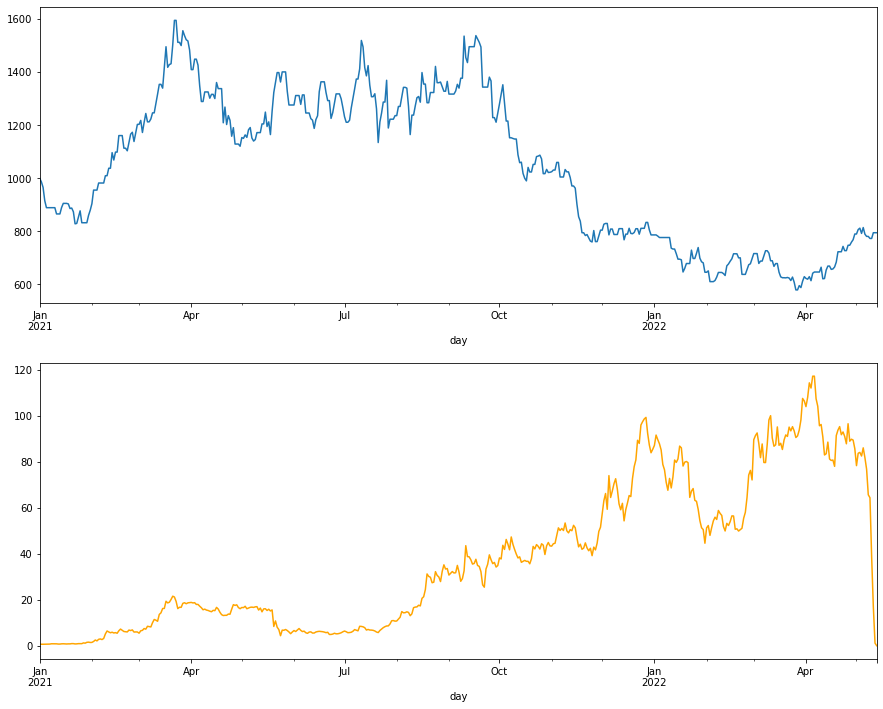

In [4]:
strat = random_strat(
    df = df.copy().loc["2021":],
    open_proba = 1/24,
    close_proba = 1/24,
    take_profit_pct = 0.03,
    stop_loss_pct = 0.05   
)

strat.populate_indicators()
temp = strat.populate_buy_sell(show_log=True)
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=bt_result['days'])

In [5]:
simuls = []
for i in range(1000):
    
    open_proba = 1 / random.randint(12,72)
    close_proba = 1 / random.randint(12,72)
    take_profit_pct = random.randint(1,12) / 100 if bool(random.getrandbits(1)) else 0
    stop_loss_pct = random.randint(1,12) / 100 if bool(random.getrandbits(1)) else 0
    
    strat = random_strat(
        df = df.copy().loc["2021":],
        open_proba = open_proba,
        close_proba = close_proba,
        take_profit_pct = take_profit_pct,
        stop_loss_pct = stop_loss_pct  
    )

    strat.populate_indicators()
    temp = strat.populate_buy_sell(show_log=False)
    bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")
    simuls.append({
        "sharpe_ratio": bt_result['sharpe_ratio'], 
        "max_drawdown": bt_result['max_drawdown'], 
        "win_rate": bt_result['win_rate'], 
        "wallet": bt_result['wallet'],
        "avg_profit": bt_result['avg_profit'], 
        "total_trades": bt_result['total_trades'], 
        "take_profit_pct": bt_result['take_profit_pct'],
        "stop_loss_pct": bt_result['stop_loss_pct'],
        "open_proba": bt_result['open_proba'],
        "close_proba": bt_result['close_proba'],
        "bt_type": bt_result['bt_type'],
    })
    print(i, end='')


0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338339340341342343344345346347348349350351352353354355356357358359360361362363364365366367368369

In [6]:
df_simul = pd.DataFrame(simuls)
df_simul

,sharpe_ratio,max_drawdown,win_rate,wallet,avg_profit,total_trades,take_profit_pct,stop_loss_pct,open_proba,close_proba,bt_type
0,-0.102000,-99.997478,0.474419,1468.875780,0.002897,215,0.00,0.00,0.023256,0.066667,random
1,-0.962443,-53.132393,0.420091,513.611780,-0.003560,219,0.04,0.03,0.019608,0.045455,tp_and_sl
2,0.630664,-99.998012,0.529412,2358.752009,0.012600,119,0.00,0.00,0.016667,0.022727,random
3,0.445852,-74.378234,0.621129,863.622405,-0.000189,549,0.03,0.00,0.076923,0.055556,only_tp
4,1.771755,-58.419000,0.445946,7960.319306,0.023496,148,0.00,0.10,0.024390,0.017857,only_sl
...,...,...,...,...,...,...,...,...,...,...,...
995,1.019682,-96.300672,0.475728,1314.918643,0.012271,206,0.00,0.00,0.045455,0.027778,random
996,-2.519638,-43.446769,0.300578,568.793656,-0.004168,173,0.02,0.01,0.014925,0.016949,tp_and_sl
997,-0.003626,-80.073301,0.761062,493.468317,-0.001129,226,0.02,0.00,0.024390,0.027778,only_tp
998,-0.460057,-68.070556,0.232323,570.709398,-0.002088,297,0.10,0.02,0.028571,0.019608,tp_and_sl


In [7]:
metrics = "sharpe_ratio"
print("Mean", metrics, "random entry and exit:", round(df_simul.loc[(df_simul["bt_type"] == "random")][metrics].mean(), 2))
print("Mean", metrics, "random entry and exit with only TP:", round(df_simul.loc[(df_simul["bt_type"] == "only_tp")][metrics].mean(), 2))
print("Mean", metrics, "random entry and exit with only SL:", round(df_simul.loc[(df_simul["bt_type"] == "only_sl")][metrics].mean(), 2))
print("Mean", metrics, "random entry and exit with TP and SL:", round(df_simul.loc[(df_simul["bt_type"] == "tp_and_sl")][metrics].mean(), 2))
df_simul.sort_values(metrics, ascending=False)

Mean sharpe_ratio random entry and exit: 0.66
Mean sharpe_ratio random entry and exit with only TP: 0.15
Mean sharpe_ratio random entry and exit with only SL: 1.13
Mean sharpe_ratio random entry and exit with TP and SL: -0.23


,sharpe_ratio,max_drawdown,win_rate,wallet,avg_profit,total_trades,take_profit_pct,stop_loss_pct,open_proba,close_proba,bt_type
621,2.991638,-39.687340,0.515152,87383.243654,0.046629,132,0.00,0.11,0.028571,0.016393,only_sl
627,2.751625,-55.468818,0.503546,67685.385363,0.042814,141,0.00,0.12,0.031250,0.015152,only_sl
802,2.617978,-57.174465,0.589888,29939.879460,0.021241,178,0.10,0.00,0.033333,0.020000,only_tp
261,2.528543,-57.285364,0.471154,34564.766848,0.051658,104,0.00,0.00,0.014085,0.021739,random
331,2.485266,-63.513089,0.507042,23233.530484,0.018973,213,0.00,0.11,0.035714,0.030303,only_sl
...,...,...,...,...,...,...,...,...,...,...,...
594,-3.147021,-73.997681,0.661238,260.023187,-0.005221,307,0.01,0.03,0.027778,0.040000,tp_and_sl
291,-3.582738,-75.165091,0.408333,248.349091,-0.006602,240,0.02,0.02,0.020833,0.016949,tp_and_sl
804,-3.658396,-88.101637,0.697068,121.550979,-0.004271,614,0.01,0.03,0.062500,0.026316,tp_and_sl
346,-3.672678,-95.153150,0.527820,49.744924,-0.005219,665,0.02,0.03,0.066667,0.030303,tp_and_sl


<AxesSubplot:xlabel='bt_type', ylabel='sharpe_ratio'>

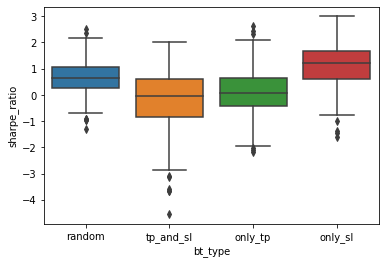

In [8]:
sns.boxplot(x="bt_type", y=metrics, data=df_simul)

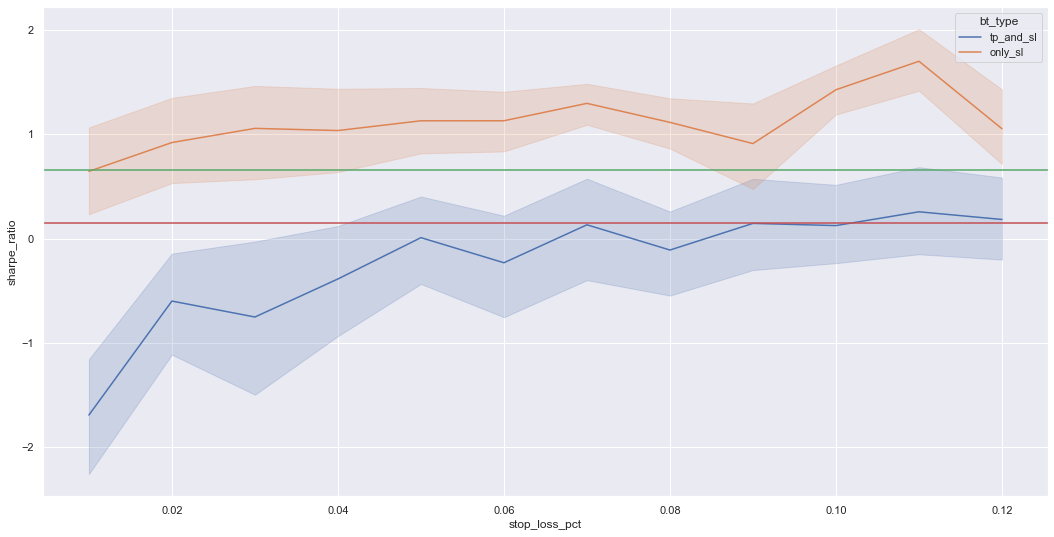

In [9]:
sns.set(rc={'figure.figsize':(18,9)})
sns.lineplot(x = "stop_loss_pct", y = metrics, hue = "bt_type", data = df_simul.loc[(df_simul["bt_type"] == "only_sl") | (df_simul["bt_type"] == "tp_and_sl")])
plt.axhline(y=df_simul.loc[(df_simul["bt_type"] == "random")][metrics].mean(), color='g', linestyle='-')
plt.axhline(y=df_simul.loc[(df_simul["bt_type"] == "only_tp")][metrics].mean(), color='r', linestyle='-')

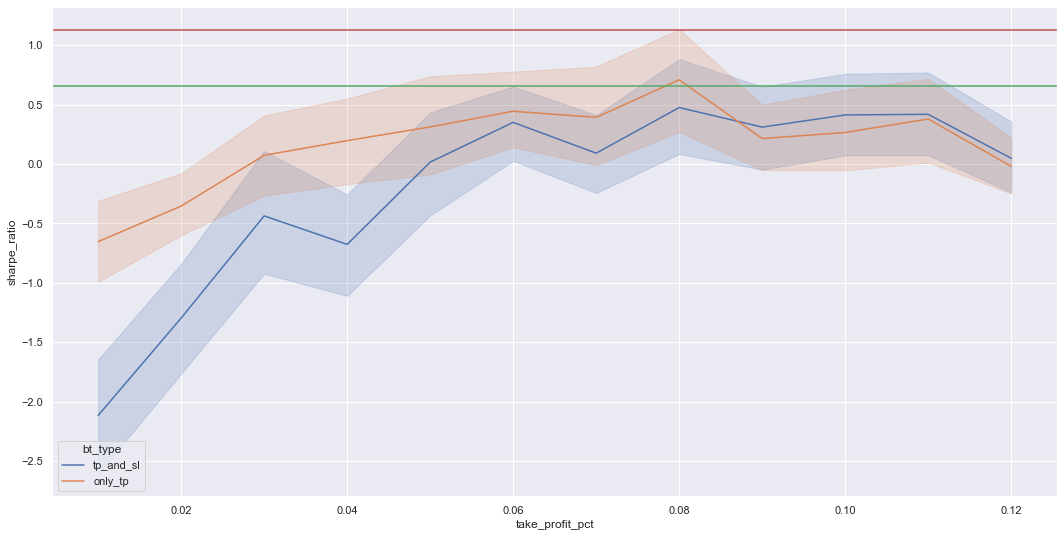

In [10]:
sns.lineplot(x = "take_profit_pct", y = metrics, hue="bt_type", data = df_simul.loc[(df_simul["bt_type"] == "only_tp") | (df_simul["bt_type"] == "tp_and_sl")])
plt.axhline(y=df_simul.loc[(df_simul["bt_type"] == "random")][metrics].mean(), color='g', linestyle='-')
plt.axhline(y=df_simul.loc[(df_simul["bt_type"] == "only_sl")][metrics].mean(), color='r', linestyle='-')

In [11]:
df_simul["bt_type"].value_counts()

random       261
only_tp      258
only_sl      247
tp_and_sl    234
Name: bt_type, dtype: int64